In [24]:
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Rescaling,RandomRotation,RandomFlip,Dropout
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input,Model

In [25]:
#Import all the necessary libraries
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [26]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('images/Set1',validation_split=0.3,subset='training',seed=123,batch_size=25, image_size=(224, 224))

Found 14179 files belonging to 11 classes.
Using 8508 files for training.


In [27]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory('images/Set1',validation_split=0.3,subset='validation',seed=123,batch_size=25,image_size=(224,224))

Found 14179 files belonging to 11 classes.
Using 5671 files for validation.


In [28]:
#Create a base model for ResNet50
resnet50 = ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False
)

In [21]:
resnet50.trainable = False #All the pretrained weights and biases are retrieved for fine tuning

In [15]:
inputs = Input(shape=(224, 224, 3)) #The input size is (224,224,3)
inputs = Rescaling(1./255)(inputs) #To normalize the dataset
inputs = RandomFlip("horizontal_and_vertical")(inputs) #RandomFlip, RandomRotation are data Augementation to enhance good results
inputs = RandomRotation(0.2)(inputs)
x = resnet50(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=1024,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(units=512,activation="relu")(x)
outputs = Dense(units=10,activation="softmax")(x)
model = Model(inputs, outputs)

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
history = model.fit(x=train_dataset, validation_data=validation_dataset, epochs=30)

Epoch 1/30
398/398 [==============================] - 71s 170ms/step - loss: 0.7167 - accuracy: 0.7426 - val_loss: 0.4086 - val_accuracy: 0.8566
Epoch 2/30
398/398 [==============================] - 68s 170ms/step - loss: 0.2963 - accuracy: 0.8966 - val_loss: 0.2061 - val_accuracy: 0.9285
Epoch 3/30
398/398 [==============================] - 67s 168ms/step - loss: 0.1599 - accuracy: 0.9452 - val_loss: 0.1818 - val_accuracy: 0.9407
Epoch 4/30
398/398 [==============================] - 68s 170ms/step - loss: 0.1128 - accuracy: 0.9614 - val_loss: 0.2107 - val_accuracy: 0.9438
Epoch 5/30
398/398 [==============================] - 67s 167ms/step - loss: 0.0789 - accuracy: 0.9734 - val_loss: 0.2111 - val_accuracy: 0.9391
Epoch 6/30
398/398 [==============================] - 69s 173ms/step - loss: 0.1157 - accuracy: 0.9643 - val_loss: 0.1227 - val_accuracy: 0.9610
Epoch 7/30
398/398 [==============================] - 68s 169ms/step - loss: 0.0599 - accuracy: 0.9794 - val_loss: 0.0893 - val_ac

In [5]:
#This saves the state of the Model we trained
import os.path

if os.path.isfile('models/resnet50.h5') is False:
    model.save('models/resnet50.h5')#Saves the architecture as well as weights and biases
if os.path.isfile('models/resnet50_weights.h5') is False:
    model.save_weights('models/resnet50_weights.h5')#Only saves the weight and biases

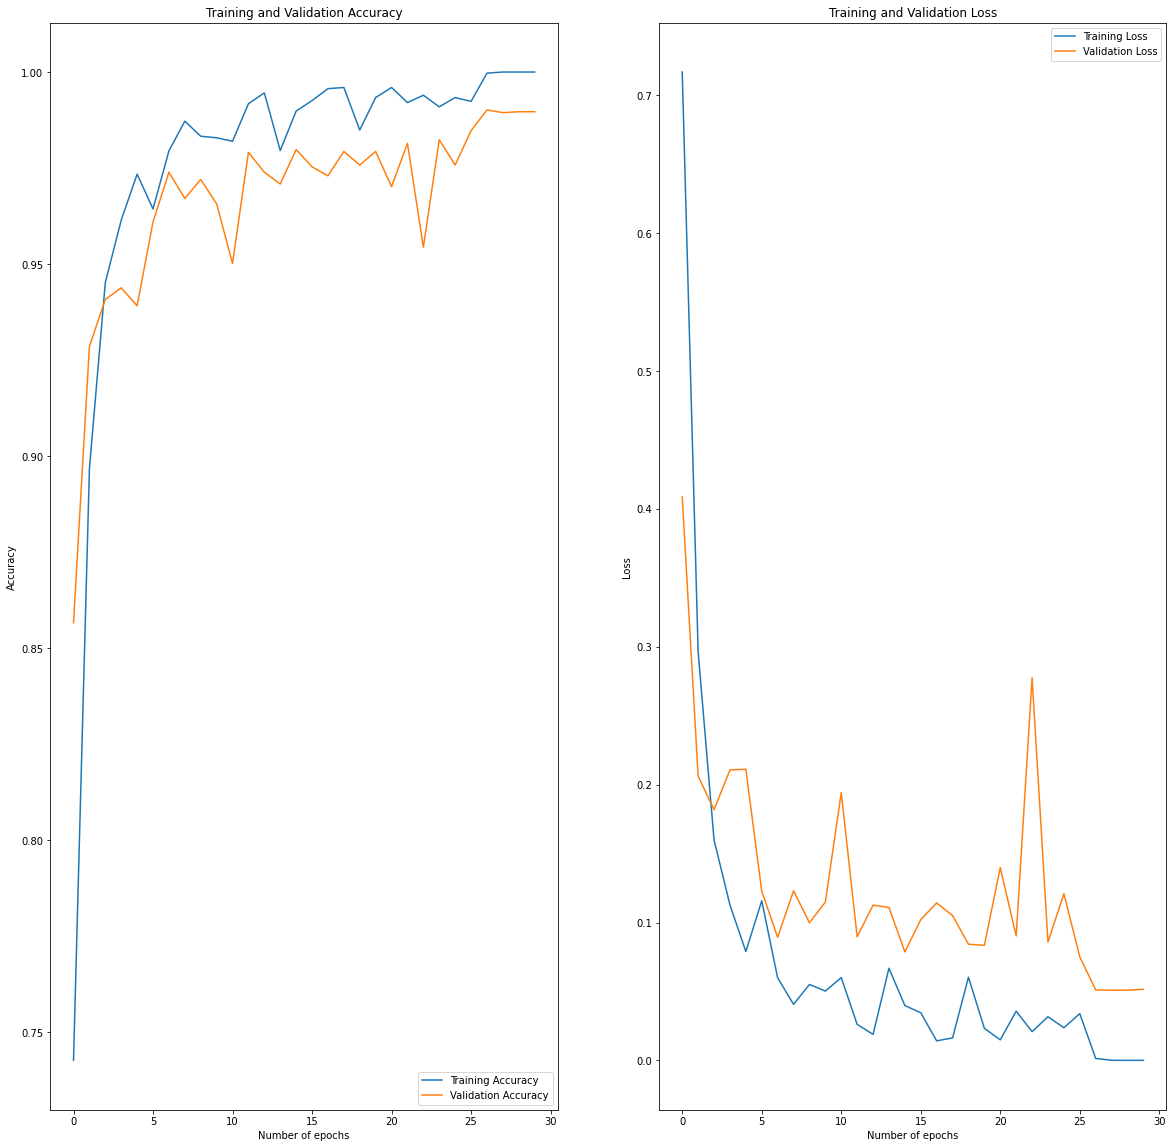

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))

def performanceGraph():
    
    accuracy = history.history['accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    
    epochs_range=range(30)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')    
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    
    
    plt.savefig('subplot.png')
    plt.show()

performanceGraph()

In [8]:
from tensorflow.keras.models import load_model
model = load_model("models/resnet50.h5")

In [23]:
import random
#'images/Set1/1.57-Red_Deer/SEQ79911/SEQ79911_IMG_0003.JPG'
#'images/Set1/1.27-White_Tailed_Deer/SEQ87147/SEQ87147_IMG_0001.JPG'
class_names = train_dataset.class_names

img = tf.keras.utils.load_img(
    'testimages/', target_size=(224,224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 44ms/step
This image most likely belongs to 1.56-Mouflon with a 14.80 percent confidence.
tf.Tensor(
[ 9.373636  9.467423  9.127231  9.741237  9.176889 14.803293  9.467776
 10.326171  9.415882  9.100459], shape=(10,), dtype=float32)


In [10]:
#Script to see out Dataset
import matplotlib.pyplot as plt
def display(display_list):
    plt.figure(figsize = (20,20))
    for images,labels in display_list.take(1):
        for i in range(9):
            plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

In [125]:
prediction = tf.keras.preprocessing.image_dataset_from_directory(f"images/Set1/{class_names[np.argmax(score)]}")

Found 794 files belonging to 100 classes.


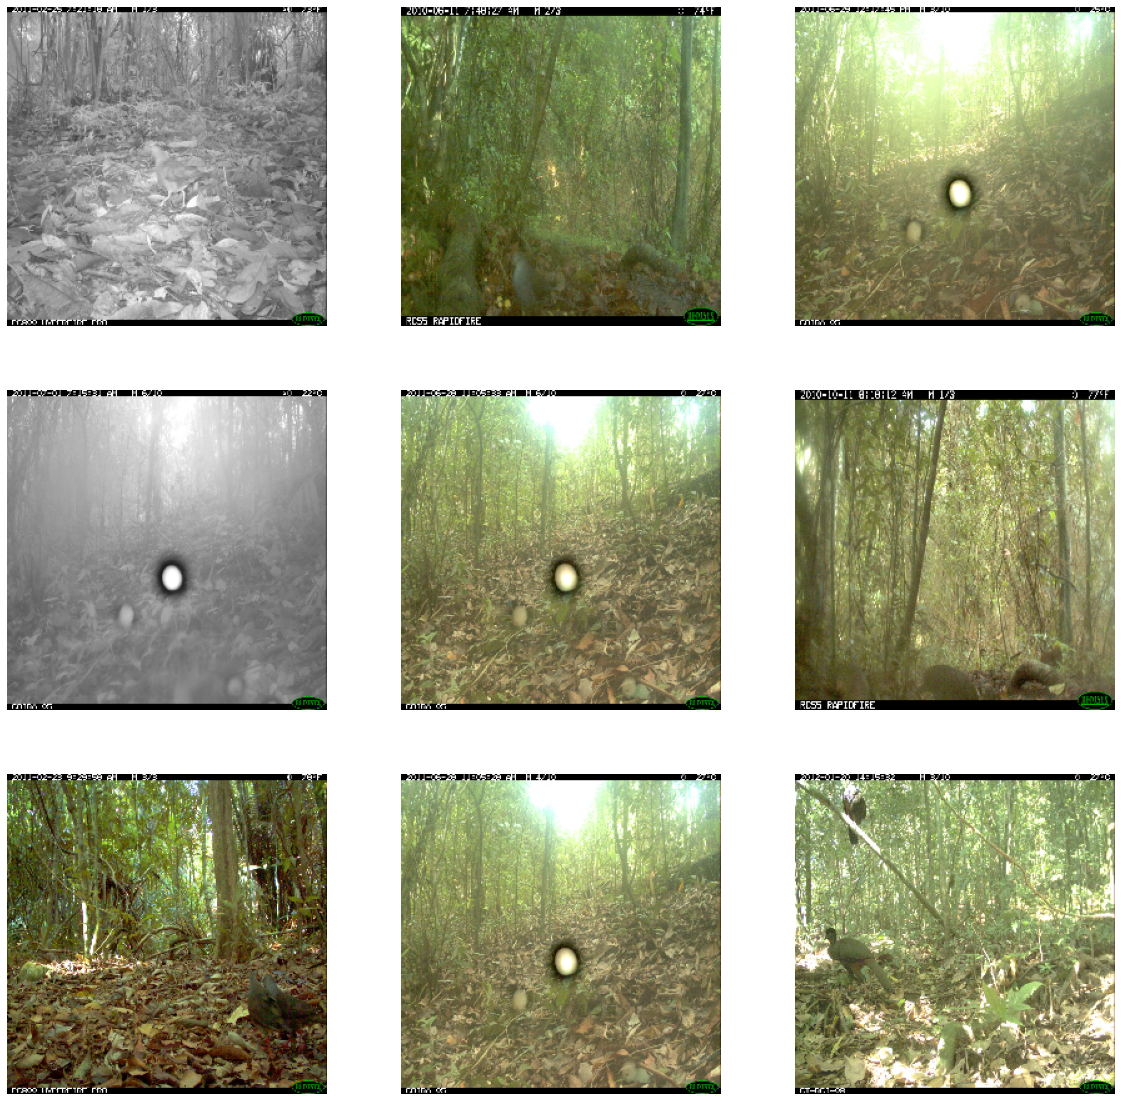

In [126]:
display(prediction)